In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.restoration import denoise_nl_means, estimate_sigma
import scipy.signal as sig
from scipy.signal import hilbert
from scipy.optimize import curve_fit
from skimage.restoration import unwrap_phase
from scipy.ndimage import gaussian_filter
import tifffile as tif

In [11]:

def non_local_means_despeckling_3d(volume, h=None, search_window_size=21, block_size=5):
    if h is None:
        # If 'h' is not provided, estimate it from the input volume
        sigma_estimated = estimate_sigma(volume, average_sigmas=True)
        h = 0.8 * sigma_estimated
        
    # Apply the 3D Non-local Means filter
    despeckled_volume = denoise_nl_means(volume, h=h, fast_mode=True, patch_size=block_size, patch_distance=search_window_size)

    return despeckled_volume


def stabilize_phase_y_gaussian_filter(oct_data, sigma=10):
    # Compute the phase of the complex OCT data
    phase_data = np.angle(oct_data)

    # Unwrap the phase along the y-axis
    unwrapped_phase_data = np.unwrap(phase_data, axis=1)#/np.max(np.unwrap(phase_data, axis=1),axis=0)

    # Apply Gaussian filter along the y-axis
    filtered_unwrapped_phase_data = gaussian_filter(unwrapped_phase_data, sigma=(sigma, 0))

    # Subtract the filtered unwrapped phase from the original unwrapped phase
    stabilized_unwrapped_phase_data = unwrapped_phase_data - filtered_unwrapped_phase_data

    # Reconstruct the OCT data with the stabilized phase
    stabilized_oct_data = np.abs(oct_data) * np.exp(1j * stabilized_unwrapped_phase_data)
    return stabilized_oct_data


In [3]:
""" Load tomograms"""
# rootFolder = 'D:/DLOCT/TDG/OCT_Real/nueva data/' # s.eye_swine
# fnameTom = '[p.SHARP][s.Eye2a][10-09-2019_13-14-42]_TomJones_z=(586)_x=(512)_y=(512)'# s.eye_swine
rootFolder = 'D:/DLOCT/TomogramsDataAcquisition/'

fnameTom = 'ExperimentalTomogram/ExperimentalROI_corrected5'

# Shape of each tomogram, as tuples (Z, X, Y)
# tomShape = [(586,512,512)] # s.eye_swine
tomShape = [(350,384,384)]
fname = rootFolder + fnameTom
# Names of all real and imag .bin files
fnameTomReal = [fname + '_real.bin' ]
fnameTomImag = [fname + '_imag.bin' ]
z = 128


In [4]:
tomReal = np.fromfile(fnameTomReal[0]) # quit single for porcine cornea and put single for s_eye
tomReal = tomReal.reshape(tomShape[0], order='F')  # reshape using # Fortran style to import according to MATLAB

tomImag = np.fromfile(fnameTomImag[0])
tomImag = tomImag.reshape(tomShape[0], order='F')  # reshape using # Fortran style to import according to MATLAB

# tomData = np.stack((tomReal, tomImag), axis=3)
tomData = tomReal + 1j*tomImag

Text(0.5, 1.0, 'Original')

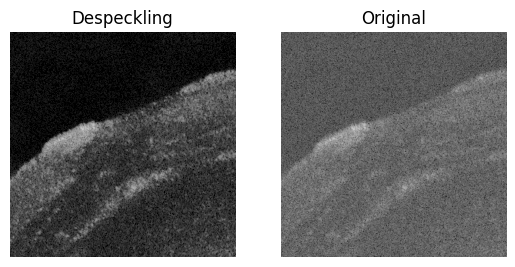

In [12]:
i = 128
filtered_volumer = non_local_means_despeckling_3d(np.real(tomData[i,:,:]))
filtered_volumei = non_local_means_despeckling_3d(np.imag(tomData[i,:,:]))
fig,axs = plt.subplots(1,2)
axs[0].imshow(10*np.log10(abs(filtered_volumer+1j*filtered_volumei)**2),cmap='gray',vmin=30, vmax=100)
axs[0].set_axis_off()
axs[0].set_title('Despeckling')
axs[1].imshow(10*np.log10(abs(tomData[i,:,:])**2),cmap='gray',vmin=30, vmax=100)
axs[1].set_axis_off()
axs[1].set_title('Original')


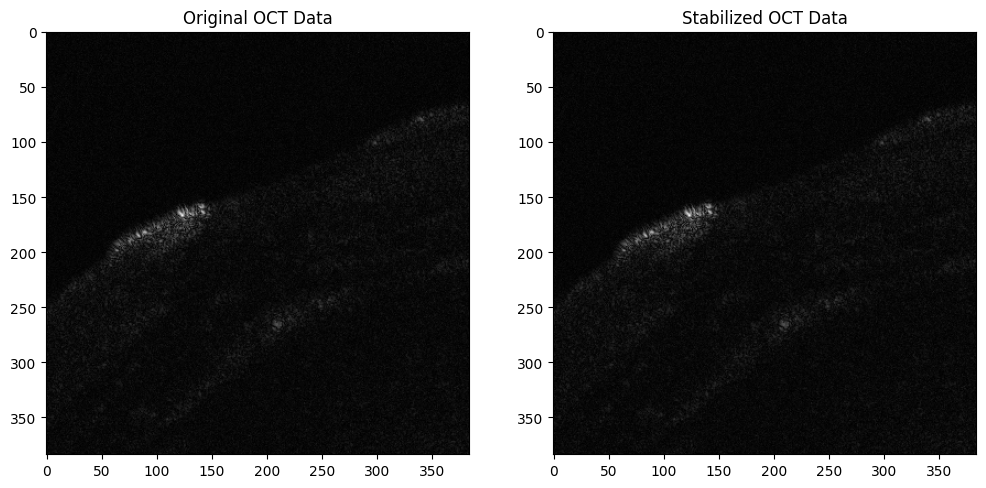

In [5]:

# Stabilize phase along y-axis using Gaussian fit
stabilized_oct_data = stabilize_phase_y_gaussian_filter(tomData[z,:,:])

# Visualize original and stabilized OCT data
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(np.abs(tomData[z,:,:]), cmap='gray')
ax[0].set_title('Original OCT Data')
ax[1].imshow(np.abs(stabilized_oct_data), cmap='gray')
ax[1].set_title('Stabilized OCT Data')
plt.show()
    


In [13]:
filtered_volumer = np.zeros(tomReal.shape)
filtered_volumei = np.zeros(tomReal.shape)
for i in range(tomData.shape[0]):
    filtered_volumer[i,:,:] = non_local_means_despeckling_3d(np.real(tomData[i,:,:]))
    filtered_volumei[i,:,:] = non_local_means_despeckling_3d(np.imag(tomData[i,:,:]))
     # calculate the progress percentage
    progress = (i + 1) / tomData.shape[0]
    # calculate the number of characters to print
    num_chars = int(progress * 20)
    # print the load bar
    print(f'[{num_chars * "#"}{(20 - num_chars) * "-"}] {int(progress * 100)}%', end='\r')

Text(0.5, 1.0, 'Original')

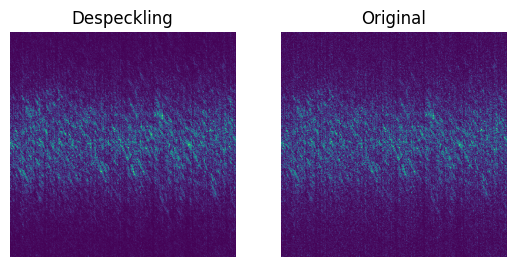

In [9]:

ft_despeck = np.fft.fftshift(np.fft.fft2(np.fft.fftshift(filtered_volumer[z,:,:]+1j*filtered_volumei[z,:,:])))
ft_original = np.fft.fftshift(np.fft.fft2(np.fft.fftshift(tomData[z,:,:])))
# ft_corrected = np.fft.fftshift(np.fft.fft2(np.fft.fftshift(stabilized_oct_data)))
ps_despeck = abs(ft_despeck)**2/np.max(abs(ft_despeck)**2,axis=0)
ps_orig = abs(ft_original)**2/np.max(abs(ft_original)**2,axis=0)
# ps_corrected = (abs(ft_corrected)**2)/np.max(abs(ft_corrected)**2,axis=0)
fig,axs = plt.subplots(1,2)
axs[0].imshow(ps_despeck)
axs[0].set_axis_off()
axs[0].set_title('Despeckling')
axs[1].imshow(ps_orig)
axs[1].set_axis_off()
axs[1].set_title('Original')
# axs[2].imshow(ps_corrected)
# axs[2].set_axis_off()
# axs[2].set_title('corrected')
# gaussian_filter()

Text(0.5, 1.0, 'Original')

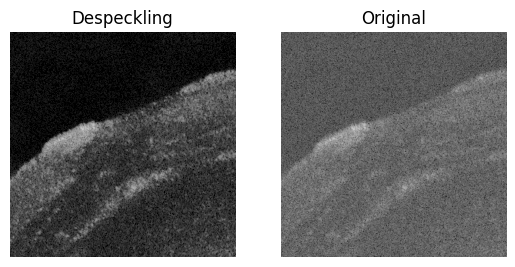

In [14]:
z =128
fig,axs = plt.subplots(1,2)
axs[0].imshow(10*np.log10(abs(filtered_volumer[z,:,:]+1j*filtered_volumei[z,:,:])**2),cmap='gray',vmin=30, vmax=100)
axs[0].set_axis_off()
axs[0].set_title('Despeckling')
axs[1].imshow(10*np.log10(abs(tomData[z,:,:])**2),cmap='gray',vmin=30, vmax=100)
axs[1].set_axis_off()
axs[1].set_title('Original')
# axs[2].imshow(10*np.log10(abs(stabilized_oct_data)**2),cmap='gray',vmin=30, vmax=100)
# axs[2].set_axis_off()
# axs[2].set_title('phase correct')

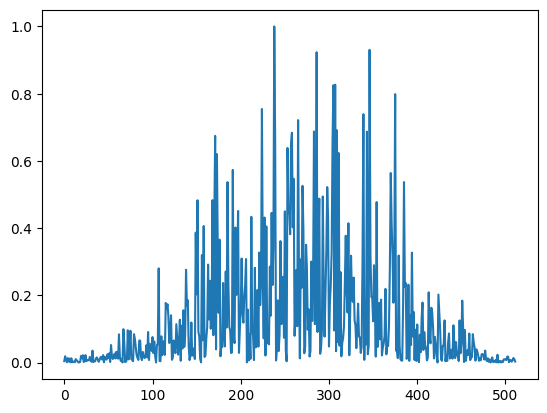

In [185]:
plt.plot(ps_corrected[:,256])

c:\Users\diego\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


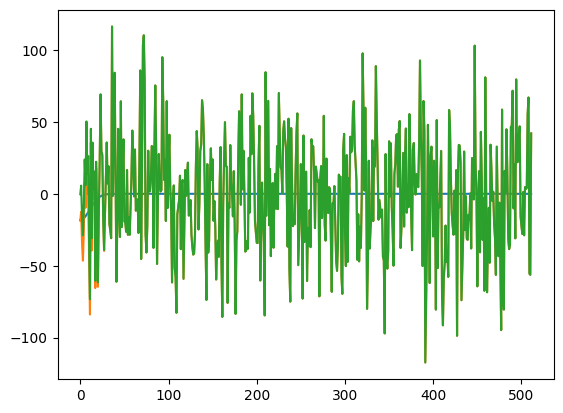

In [221]:
y = np.arange(tomData[z,:,:].shape[0])
# Compute the phase of the complex OCT data
phase_data = np.angle(tomData[z,:,:])
gaussian_phase_y = np.zeros_like(phase_data)
# Unwrap the phase along the y-axis
unwrapped_phase_data = np.unwrap(phase_data,axis=1)
for col in range(tomData[z,:,:].shape[1]):
    amp, mu, sigma = fit_gaussian(y, unwrapped_phase_data[:, col])
    gaussian_phase_y[:, col] = gaussian(y, amp, mu, sigma)

stabilized_unwrapped_phase_data = unwrapped_phase_data - gaussian_phase_y

plt.plot(gaussian_phase_y[:,500])
plt.plot(unwrapped_phase_data[:,500])
plt.plot(unwrapped_phase_data[:,500]-gaussian_phase_y[:,500])


In [15]:
# save the array to a binary file

# zini = 90
# zfin = 390
# binfilei = filtered_volumer[zini:zfin,:,:]
# binfiler = filtered_volumer[zini:zfin,:,:] 
# fnametom2 = '[p.SHARP][s.Eye2a][10-09-2019_13-14-42]_TomJones_z=(300)_x=(512)_y=(512)_despeckled'
fnametom2 = 'ExperimentalTomogram/ExperimentalROI_corrected5_despeckled'
fname2 = rootFolder + fnametom2
fnameTomReal2 = [fname2 + '_real.bin' ]
fnameTomImag2 = [fname2 + '_imag.bin' ]

#save in numpy file
fnameReal = fname2 + '_real.npy'
fnameImag = fname2 + '_imag.npy'
np.save(fnameReal, filtered_volumer)
np.save(fnameImag, filtered_volumei)



# save in bin format
# binfiler = np.asfortranarray(binfiler).astype('float')
# with open(fnameTomReal2[0], 'wb') as fid:
#     fid.write(np.array([binfiler.size],dtype='int32').tobytes())
#     binfiler.tofile(fid)

# print('ok')    
# # binfilei = np.asfortranarray(binfilei).astype('float')
# with open(fnameTomImag2[0], 'wb') as fid:
#     fid.write(np.array([binfilei.size],dtype= 'int32').tobytes())
#     binfilei.tofile(fid)
       


In [17]:
# Save tif 3D
save = 10*np.log10(abs(filtered_volumer+1j*filtered_volumei)**2)
tif.imwrite(rootFolder+'\\cornea_despeckling.tif', save)

C:\Users\diego\AppData\Local\Temp\ipykernel_10584\874884379.py:15: RuntimeWarning: overflow encountered in square
  plt.imshow(10*np.log(abs(tomReal2[s,:,:]+1j*tomImag2[s,:,:])**2))
C:\Users\diego\AppData\Local\Temp\ipykernel_10584\874884379.py:15: RuntimeWarning: divide by zero encountered in log
  plt.imshow(10*np.log(abs(tomReal2[s,:,:]+1j*tomImag2[s,:,:])**2))


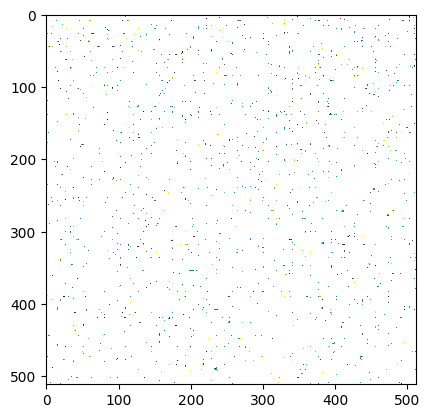

In [76]:
rootFolder = 'D:/DLOCT/TDG/OCT_Real/nueva data/' # s.eye_swine
fnameTom = '[p.SHARP][s.Eye2a][10-09-2019_13-14-42]_TomJones_z=(300)_x=(512)_y=(512)_despeckled'# s.eye_swine
# Shape of each tomogram, as tuples (Z, X, Y)
tomShape = [(300,512,512)] # s.eye_swine
fname = rootFolder + fnameTom
# Names of all real and imag .bin files
fnameTomReal = [fname + '_real.bin' ]
fnameTomImag = [fname + '_imag.bin' ]
tomReal2 = np.fromfile(fnameTomReal[0]) # quit single for porcine cornea and put single for s_eye
tomReal2 = tomReal2.reshape(tomShape[0],)  # reshape using # Fortran style to import according to MATLAB

tomImag2 = np.fromfile(fnameTomImag[0])
tomImag2 = tomImag2.reshape(tomShape[0])  # reshape using # Fortran style to import according to MATLAB
s = 12
plt.imshow(10*np.log(abs(tomReal2[s,:,:]+1j*tomImag2[s,:,:])**2))

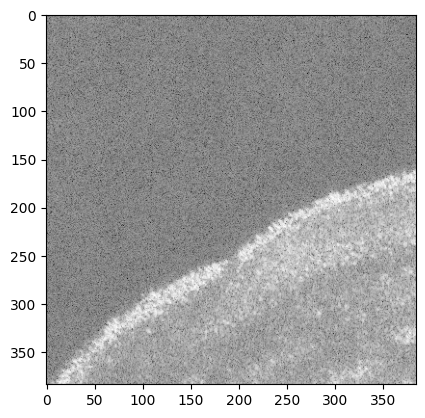

In [16]:
# fnametom2 = '[p.SHARP][s.Eye2a][10-09-2019_13-14-42]_TomJones_z=(300)_x=(512)_y=(512)_despeckled'
fnametom2 = 'ExperimentalTomogram/ExperimentalROI_corrected5_despeckled'
fname2 = rootFolder + fnametom2
fnameReal = fname2 + '_real.npy'
fnameImag = fname2 + '_imag.npy'
real = np.load(fnameReal)
imag = np.load(fnameImag)
s = 12
plt.imshow(10*np.log(abs(real[s,:,:]+1j*imag[s,:,:])**2),cmap='gray')
